In [ ]:
import tensorflow as tf

In [ ]:
use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)


# if use_tpu:
#   # Create model on TPU:
#   with strategy.scope():
#     model = create_model1()
#     optimizer = tf.keras.optimizers.Adam()
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# else:
#   model = create_model1()
#   model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [ ]:
def tpu_model(create_model, use_tpu=True):
  if use_tpu:
    # Create model on TPU:
    with strategy.scope():
      model = create_model()
  else:
    model = create_model()
  return model


# Lab 3 - Neural Network Classifier Using Simple Word Embeddings



---















In this session, we demonstrate how to solve a text classification task using different neural classifiers. We will also experiment with different ways to use word embeddings for classification.

We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with different word embeddings and add a layer to see how much that improves the performance. We will finally use CNNs to address the problem.

We are going to use Keras Sequential API in this session. The Sequential API allows you to build models layer-by-layer.

In [ ]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, LSTM, Input
from keras import backend as K
from keras.models import Sequential
from keras.utils import pad_sequences


import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50,000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, we usually limit the size of the vocabulary to stop the data from becoming too sparse, creating possible overfitting. We hence keep the top 10,000 most frequently occurring words in the training data.


In [ ]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 1s 0us/step


We now can start look into the data, let’s first see the length:

In [ ]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [ ]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [ ]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [ ]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in NLP tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then it multiplies these vectors by the embedding matrix to get relevant vectors. But there is no way to get a one-hot vector as the output of a layer in Keras. To solve this we use the Lambda() layer and a function that creates the one-hot layer. 

In [ ]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to int (Keras passes around float tensors by default).



In most cases, each text sequence has a different length in words. Hence, we fill sequences with a pad token (0) accordingly. This special token is then masked not to be accounted for in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = pad_sequences(X_train, value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = pad_sequences(X_test, value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [ ]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we will build our neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been shown that such an unweighted average of word vectors outperforms more complex networks (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


#Model 1: Neural network model using one-hot vectors

The first layer is a one-hot layer. The second layer computes average of all word vectors in a sentence without considering padding. The output vector is then piped through a fully-connected layer. The last layer has a single output node with the sigmoid activation function. The final value is a float between 0 and 1. At the end we visualize the model summary.

In [ ]:
# your code goes here

def create_model1():
  
  return Sequential([
    OneHot(VOCAB_SIZE, MAX_SEQUENCE_LENGTH),
    GlobalAveragePooling1DMasked(),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
  ])


model1 = tpu_model(create_model1, use_tpu=True)


model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Training the model

To compile the model we need a loss function and an optimizer. We use the binary_crossentropy loss function. We also use the Adam optimizer. You can read more about it here: https://arxiv.org/abs/1412.6980v8.


In [ ]:
### Note that I do this with the tpu_model function

model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

When training, we want to check the accuracy of the model on the unseen data. So we create a validation set:

In [ ]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 16s 197ms/step - loss: 0.6752 - accuracy: 0.6228 - val_loss: 0.6587 - val_accuracy: 0.6396
Epoch 2/40
30/30 [==============================] - 3s 107ms/step - loss: 0.6381 - accuracy: 0.6819 - val_loss: 0.6242 - val_accuracy: 0.6958
Epoch 3/40
30/30 [==============================] - 5s 182ms/step - loss: 0.6052 - accuracy: 0.7134 - val_loss: 0.5994 - val_accuracy: 0.7150
Epoch 4/40
30/30 [==============================] - 2s 76ms/step - loss: 0.5771 - accuracy: 0.7348 - val_loss: 0.5684 - val_accuracy: 0.7404
Epoch 5/40
30/30 [==============================] - 2s 58ms/step - loss: 0.5526 - accuracy: 0.7483 - val_loss: 0.5473 - val_accuracy: 0.7552
Epoch 6/40
30/30 [==============================] - 2s 60ms/step - loss: 0.5324 - accuracy: 0.7589 - val_loss: 0.5305 - val_accuracy: 0.7601
Epoch 7/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5186 - accuracy: 0.7623 - val_loss: 0.5176 - val_accuracy: 0.7637
Epoch 8/4

### Evaluating the model

To evaluate the model on test data:

In [ ]:
results1 = model1.evaluate(X_test_enc, y_test)

782/782 [==============================] - 28s 34ms/step - loss: 0.4613 - accuracy: 0.7789


In [ ]:
print(results1)
# loss, accuracy     ##### Higher due to TPU

[0.46131575107574463, 0.7788800001144409]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot accuracy and loss over epochs we can use Matplotlib:

In [ ]:
history1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

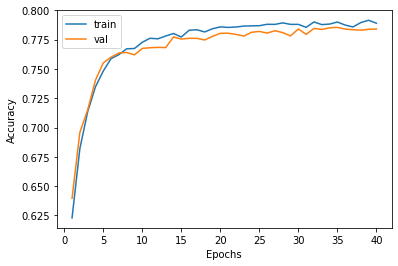

In [ ]:
# your code goes here
x = range(1,len(history1.history["accuracy"])+1)
y1_1 = history1.history["accuracy"]
y1_2 = history1.history["val_accuracy"]

plt.plot(x,y1_1, label="train")
plt.plot(x,y1_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

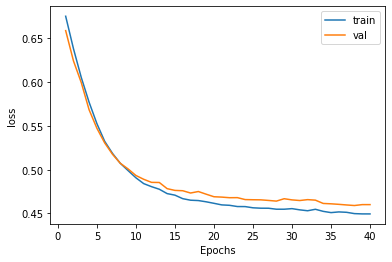

In [ ]:
# your code goes here
x = range(1,len(history1.history["loss"])+1)
y1_1 = history1.history["loss"]
y1_2 = history1.history["val_loss"]

plt.plot(x,y1_1, label="train")
plt.plot(x,y1_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

#Model 2: Neural averaging model using an embedding layer

Now instead of one-hot vectors, we want to use embeddings. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [ ]:
# your code goes here

def create_model2():
  return Sequential([
    Embedding(VOCAB_SIZE, MAX_SEQUENCE_LENGTH),
    GlobalAveragePooling1DMasked(),
    Dense(1, activation="sigmoid")
  ])

model2 = tpu_model(create_model2)

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 global_average_pooling1d_ma  (None, 256)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,560,257
Trainable params: 2,560,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 10s 193ms/step - loss: 0.6881 - accuracy: 0.5963 - val_loss: 0.6810 - val_accuracy: 0.6885
Epoch 2/40
30/30 [==============================] - 2s 72ms/step - loss: 0.6700 - accuracy: 0.7231 - val_loss: 0.6581 - val_accuracy: 0.7284
Epoch 3/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6386 - accuracy: 0.7535 - val_loss: 0.6236 - val_accuracy: 0.7470
Epoch 4/40
30/30 [==============================] - 2s 58ms/step - loss: 0.5965 - accuracy: 0.7738 - val_loss: 0.5826 - val_accuracy: 0.7572
Epoch 5/40
30/30 [==============================] - 2s 59ms/step - loss: 0.5500 - accuracy: 0.7954 - val_loss: 0.5397 - val_accuracy: 0.7940
Epoch 6/40
30/30 [==============================] - 2s 60ms/step - loss: 0.5044 - accuracy: 0.8194 - val_loss: 0.5002 - val_accuracy: 0.8143
Epoch 7/40
30/30 [==============================] - 4s 142ms/step - loss: 0.4623 - accuracy: 0.8416 - val_loss: 0.4647 - val_accuracy: 0.8289
Epoch 8/40

In [ ]:
results2 = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 21s 25ms/step - loss: 0.3105 - accuracy: 0.8746


In [ ]:
print(results2)

[0.31051069498062134, 0.8746399879455566]


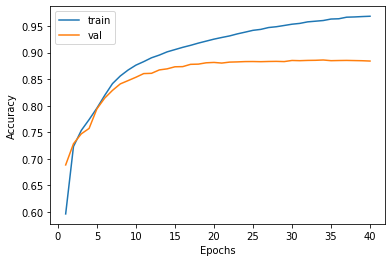

In [ ]:
# your code goes here
x = range(1,len(history2.history["accuracy"])+1)
y2_1 = history2.history["accuracy"]
y2_2 = history2.history["val_accuracy"]

plt.plot(x,y2_1, label="train")
plt.plot(x,y2_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

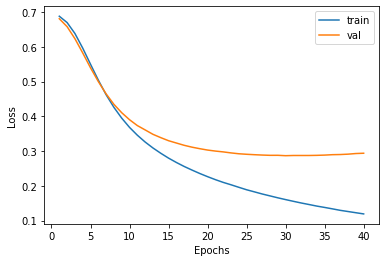

In [ ]:
# your code goes here
x = range(1,len(history2.history["loss"])+1)
y2_1 = history2.history["loss"]
y2_2 = history2.history["val_loss"]

plt.plot(x,y2_1, label="train")
plt.plot(x,y2_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

The accuracy of model2 is ~87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load pre-trained word embeddings. We are going to use GloVe embeddings (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a popular embedding technique based on factorising a matrix of word co-occurence statistics. You can download GloVe and initialise the Keras Embedding layer with weights from the pre-trained embedding model for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2023-03-07 19:10:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-07 19:10:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-07 19:10:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

We freeze the weights to create the layer: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural Network model using pre-trained word embeddings

In [ ]:
# Inspect the performance of the model with 1 hidden layer, pre-trained embeddings
# your code goes here

def create_model3():
  return Sequential([
    Input((256,)),
    embeddingLayer,
    GlobalAveragePooling1DMasked(),
    Dense(16, activation="relu"),
    Dense(1, activation="sigmoid")
  ])

model3 = tpu_model(create_model3)

model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_3 (Dense)             (None, 16)                4816      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 4,833
Non-trainable params: 120,000,300
____________________________________

In [ ]:
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results3 = model3.evaluate(X_test_enc, y_test)


Epoch 1/40
30/30 [==============================] - 8s 149ms/step - loss: 0.6906 - accuracy: 0.5445 - val_loss: 0.6874 - val_accuracy: 0.5685
Epoch 2/40
30/30 [==============================] - 2s 82ms/step - loss: 0.6839 - accuracy: 0.5699 - val_loss: 0.6808 - val_accuracy: 0.5884
Epoch 3/40
30/30 [==============================] - 2s 71ms/step - loss: 0.6780 - accuracy: 0.5858 - val_loss: 0.6758 - val_accuracy: 0.5908
Epoch 4/40
30/30 [==============================] - 2s 70ms/step - loss: 0.6722 - accuracy: 0.6013 - val_loss: 0.6705 - val_accuracy: 0.6006
Epoch 5/40
30/30 [==============================] - 2s 70ms/step - loss: 0.6664 - accuracy: 0.6075 - val_loss: 0.6653 - val_accuracy: 0.6097
Epoch 6/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6602 - accuracy: 0.6234 - val_loss: 0.6593 - val_accuracy: 0.6213
Epoch 7/40
30/30 [==============================] - 2s 71ms/step - loss: 0.6538 - accuracy: 0.6330 - val_loss: 0.6526 - val_accuracy: 0.6290
Epoch 8/40
3

In [ ]:
results3 = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 21s 26ms/step - loss: 0.5670 - accuracy: 0.7089


In [ ]:
print(results3)

[0.5669938325881958, 0.7088800072669983]


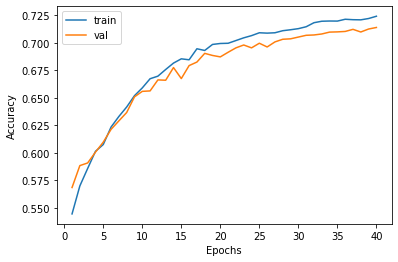

In [ ]:
# your code goes here
x = range(1,len(history3.history["accuracy"])+1)
y3_1 = history3.history["accuracy"]
y3_2 = history3.history["val_accuracy"]

plt.plot(x,y3_1, label="train")
plt.plot(x,y3_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

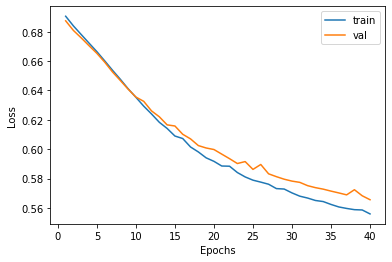

In [ ]:
# your code goes here
x = range(1,len(history3.history["loss"])+1)
y3_1 = history3.history["loss"]
y3_2 = history3.history["val_loss"]

plt.plot(x,y3_1, label="train")
plt.plot(x,y3_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

To compare freezing and fine-tuning the pre-trained embeding weights, we fine-tune the weights below:

In [ ]:
# your code goes here

def create_model4():
  return Sequential([
      Input((256, )),
      createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True),
      GlobalAveragePooling1DMasked(),
      Dense(16, activation="relu"),
      Dense(1, activation="sigmoid")
  ])

model4 = tpu_model(create_model4)
 
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_3 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_5 (Dense)             (None, 16)                4816      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 120,005,133
Trainable params: 120,005,133
Non-trainable params: 0
________________________________________

In [ ]:
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4 = model4.evaluate(X_test_enc, y_test)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 19s 331ms/step - loss: 0.6898 - accuracy: 0.5603 - val_loss: 0.6849 - val_accuracy: 0.5845
Epoch 2/40
30/30 [==============================] - 4s 147ms/step - loss: 0.6780 - accuracy: 0.6201 - val_loss: 0.6690 - val_accuracy: 0.6398
Epoch 3/40
30/30 [==============================] - 4s 134ms/step - loss: 0.6521 - accuracy: 0.6748 - val_loss: 0.6330 - val_accuracy: 0.6901
Epoch 4/40
30/30 [==============================] - 4s 152ms/step - loss: 0.5993 - accuracy: 0.7313 - val_loss: 0.5720 - val_accuracy: 0.7435
Epoch 5/40
30/30 [==============================] - 6s 199ms/step - loss: 0.5261 - accuracy: 0.7872 - val_loss: 0.4980 - val_accuracy: 0.8008
Epoch 6/40
30/30 [==============================] - 4s 138ms/step - loss: 0.4473 - accuracy: 0.8350 - val_loss: 0.4321 - val_accuracy: 0.8310
Epoch 7/40
30/30 [==============================] - 4s 148ms/step - loss: 0.3816 - accuracy: 0.8604 - val_loss: 0.3849 - val_accuracy: 0.8512
Epoch 8/40
30/30

In [ ]:
results4 = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 26s 27ms/step - loss: 0.4908 - accuracy: 0.8551


In [ ]:
print(results4)

[0.49078550934791565, 0.8550800085067749]


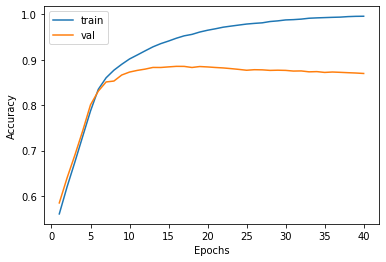

In [ ]:
# your code goes here
x = range(1,len(history4.history["accuracy"])+1)
y4_1 = history4.history["accuracy"]
y4_2 = history4.history["val_accuracy"]

plt.plot(x,y4_1, label="train")
plt.plot(x,y4_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

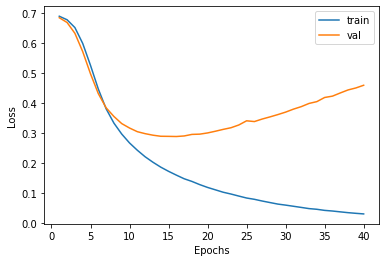

In [ ]:
# your code goes here
x = range(1,len(history4.history["loss"])+1)
y4_1 = history4.history["loss"]
y4_2 = history4.history["val_loss"]

plt.plot(x,y4_1, label="train")
plt.plot(x,y4_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

**Note**: Use frozen pre-trained embeddings in the subsequent experiments.

##  Model 3-2: LSTM with pre-trained word embeddings

In lab 2, we have conducted an experiment with LSTMs. Now, we replace its embeddings with the pre-trained GLOVE embeddings.

In [ ]:
def create_model3_2(isTrainable):
  return Sequential([
    Input((256,)),
    createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=isTrainable),
    LSTM(100),
    Dense(1)
  ])

model3_2_trainable = tpu_model(lambda : create_model3_2(isTrainable=True))

model3_2_trainable.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3_2_trainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history3_2_trainable = model3_2_trainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results3_2_trainable = model3_2_trainable.evaluate(X_test_enc, y_test)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 29s 589ms/step - loss: 1.5863 - accuracy: 0.5119 - val_loss: 1.1544 - val_accuracy: 0.5103
Epoch 2/40
30/30 [==============================] - 9s 306ms/step - loss: 0.9959 - accuracy: 0.5249 - val_loss: 0.8899 - val_accuracy: 0.5242
Epoch 3/40
30/30 [==============================] - 9s 300ms/step - loss: 0.8739 - accuracy: 0.5478 - val_loss: 0.8553 - val_accuracy: 0.5390
Epoch 4/40
30/30 [==============================] - 9s 297ms/step - loss: 0.8467 - accuracy: 0.5724 - val_loss: 0.8432 - val_accuracy: 0.5532
Epoch 5/40
30/30 [==============================] - 9s 310ms/step - loss: 0.8283 - accuracy: 0.5879 - val_loss: 0.8402 - val_accuracy: 0.6532
Epoch 6/40
30/30 [==============================] - 9s 299ms/step - loss: 0.7992 - accuracy: 0.6060 - val_loss: 0.8539 - val_accuracy: 0.5901
Epoch 7/40
30/30 [==============================] - 9s 302ms/step - loss: 0.7831 - accuracy: 0.6173 - val_loss: 0.8712 - val_accuracy: 0.5588
Epoch 8/40
30/30

In [ ]:
results3_2_trainable = model3_2_trainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 24s 29ms/step - loss: 1.0130 - accuracy: 0.5714


In [ ]:
print(results3_2_trainable)

[1.012952208518982, 0.5713599920272827]


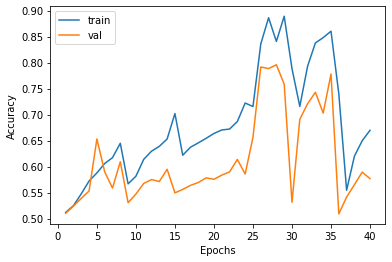

In [ ]:
# your code goes here
x = range(1,len(history3_2_trainable.history["accuracy"])+1)
y3_2_t_1 = history3_2_trainable.history["accuracy"]
y3_2_t_2 = history3_2_trainable.history["val_accuracy"]

plt.plot(x,y3_2_t_1, label="train")
plt.plot(x,y3_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

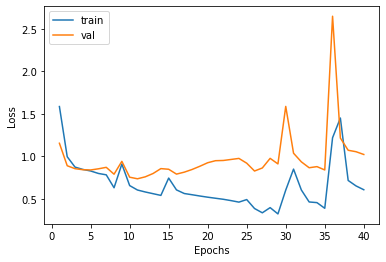

In [ ]:
# your code goes here
x = range(1,len(history3_2_trainable.history["loss"])+1)
y3_2_t_1 = history3_2_trainable.history["loss"]
y3_2_t_2 = history3_2_trainable.history["val_loss"]

plt.plot(x,y3_2_t_1, label="train")
plt.plot(x,y3_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model3_2_untrainable = tpu_model(lambda : create_model3_2(isTrainable=False))

model3_2_untrainable.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
model3_2_untrainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history3_2_untrainable = model3_2_untrainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results3_2_untrainable = model3_2_untrainable.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 13s 242ms/step - loss: 1.5171 - accuracy: 0.5100 - val_loss: 1.0250 - val_accuracy: 0.5005
Epoch 2/40
30/30 [==============================] - 3s 87ms/step - loss: 0.7994 - accuracy: 0.5103 - val_loss: 0.7141 - val_accuracy: 0.5079
Epoch 3/40
30/30 [==============================] - 2s 83ms/step - loss: 0.6952 - accuracy: 0.5183 - val_loss: 0.6950 - val_accuracy: 0.5150
Epoch 4/40
30/30 [==============================] - 2s 84ms/step - loss: 0.6874 - accuracy: 0.5253 - val_loss: 0.6913 - val_accuracy: 0.5193
Epoch 5/40
30/30 [==============================] - 3s 97ms/step - loss: 0.6840 - accuracy: 0.5349 - val_loss: 0.6890 - val_accuracy: 0.5209
Epoch 6/40
30/30 [==============================] - 3s 89ms/step - loss: 0.6801 - accuracy: 0.5399 - val_loss: 0.6870 - val_accuracy: 0.5240
Epoch 7/40
30/30 [==============================] - 3s 86ms/step - loss: 0.6759 - accuracy: 0.5424 - val_loss: 0.6848 - val_accuracy: 0.5296
Epoch 8/40


In [ ]:
results3_2_untrainable = model3_2_untrainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 24s 29ms/step - loss: 0.7186 - accuracy: 0.5864


In [ ]:
print(results3_2_untrainable)

[0.7185739278793335, 0.5863999724388123]


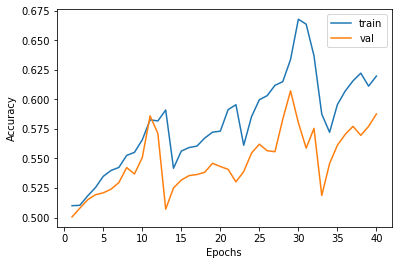

In [ ]:
# your code goes here
x = range(1,len(history3_2_untrainable.history["accuracy"])+1)
y3_2_ut_1 = history3_2_untrainable.history["accuracy"]
y3_2_ut_2 = history3_2_untrainable.history["val_accuracy"]

plt.plot(x,y3_2_ut_1, label="train")
plt.plot(x,y3_2_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

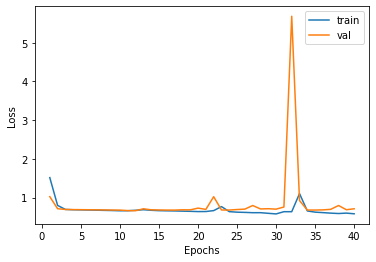

In [ ]:
# your code goes here
x = range(1,len(history3_2_untrainable.history["loss"])+1)
y3_2_ut_1 = history3_2_untrainable.history["loss"]
y3_2_ut_2 = history3_2_untrainable.history["val_loss"]

plt.plot(x,y3_2_ut_1, label="train")
plt.plot(x,y3_2_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

This experiment shows that simply replacing the lab 2 model embeddings with the pre-trained word embeddings (GLOVE) will cause performance to drop significantly. What can you do to improve the situation?

Fine-tune the word embedding, I did this above but it didn't result in the best performance increase and it was too stochastic. This is probably due to the fact that the space of the gradient of the weights is too irregular. Solutions to this are to increase the batch size or use adam with a smaller learning rate hyperparameter.

#  Model 4: Adding extra dense layer into Neural Network model

We add extra dense layers into model 3-1 to evaluate their contribution. We start by adding one layer then two. All the other parameters are the same as for model 3-1.

### Adding one extra dense layer

In [ ]:
def create_model4_1(isTrainable):
  return Sequential([
     Input((256,)),
     createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=isTrainable),
     GlobalAveragePooling1DMasked(),
     Dense(100, activation="relu"),
     Dense(16, activation="relu"),
     Dense(1, activation="sigmoid")
  ])

model4_1_trainable = tpu_model(lambda : create_model4_1(isTrainable=True))

model4_1_trainable.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 16)                1616      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

In [ ]:
model4_1_trainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history4_1_trainable = model4_1_trainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4_1_trainable = model4_1_trainable.evaluate(X_test_enc, y_test)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 20s 354ms/step - loss: 0.6803 - accuracy: 0.5829 - val_loss: 0.6622 - val_accuracy: 0.6244
Epoch 2/40
30/30 [==============================] - 4s 133ms/step - loss: 0.6353 - accuracy: 0.6573 - val_loss: 0.5994 - val_accuracy: 0.6966
Epoch 3/40
30/30 [==============================] - 4s 130ms/step - loss: 0.5267 - accuracy: 0.7687 - val_loss: 0.4691 - val_accuracy: 0.8035
Epoch 4/40
30/30 [==============================] - 4s 139ms/step - loss: 0.3938 - accuracy: 0.8424 - val_loss: 0.3824 - val_accuracy: 0.8387
Epoch 5/40
30/30 [==============================] - 4s 132ms/step - loss: 0.3110 - accuracy: 0.8755 - val_loss: 0.3322 - val_accuracy: 0.8676
Epoch 6/40
30/30 [==============================] - 4s 129ms/step - loss: 0.2592 - accuracy: 0.8988 - val_loss: 0.3166 - val_accuracy: 0.8721
Epoch 7/40
30/30 [==============================] - 4s 130ms/step - loss: 0.2149 - accuracy: 0.9201 - val_loss: 0.3017 - val_accuracy: 0.8792
Epoch 8/40
30/30

In [ ]:
results4_1_trainable = model4_1_trainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 20s 24ms/step - loss: 0.9167 - accuracy: 0.8450


In [ ]:
print(results4_1_trainable)

[0.9167017340660095, 0.8450000286102295]


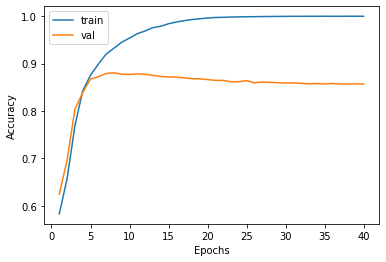

In [ ]:
# your code goes here
x = range(1,len(history4_1_trainable.history["accuracy"])+1)
y4_1_t_1 = history4_1_trainable.history["accuracy"]
y4_1_t_2 = history4_1_trainable.history["val_accuracy"]

plt.plot(x,y4_1_t_1, label="train")
plt.plot(x,y4_1_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

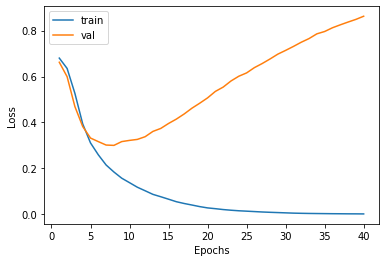

In [ ]:
# your code goes here
x = range(1,len(history4_1_trainable.history["loss"])+1)
y4_1_t_1 = history4_1_trainable.history["loss"]
y4_1_t_2 = history4_1_trainable.history["val_loss"]

plt.plot(x,y4_1_t_1, label="train")
plt.plot(x,y4_1_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model4_1_untrainable = tpu_model(lambda : create_model4_1(isTrainable=False))

model4_1_untrainable.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 dense_4 (Dense)             (None, 16)                1616      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                      

In [ ]:
model4_1_untrainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history4_1_untrainable = model4_1_untrainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4_1_untrainable = model4_1_untrainable.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 8s 154ms/step - loss: 0.6849 - accuracy: 0.5565 - val_loss: 0.6761 - val_accuracy: 0.5899
Epoch 2/40
30/30 [==============================] - 3s 97ms/step - loss: 0.6684 - accuracy: 0.5995 - val_loss: 0.6628 - val_accuracy: 0.6080
Epoch 3/40
30/30 [==============================] - 2s 68ms/step - loss: 0.6519 - accuracy: 0.6296 - val_loss: 0.6446 - val_accuracy: 0.6410
Epoch 4/40
30/30 [==============================] - 2s 69ms/step - loss: 0.6314 - accuracy: 0.6638 - val_loss: 0.6251 - val_accuracy: 0.6668
Epoch 5/40
30/30 [==============================] - 2s 66ms/step - loss: 0.6136 - accuracy: 0.6785 - val_loss: 0.6106 - val_accuracy: 0.6745
Epoch 6/40
30/30 [==============================] - 2s 64ms/step - loss: 0.6012 - accuracy: 0.6855 - val_loss: 0.6052 - val_accuracy: 0.6755
Epoch 7/40
30/30 [==============================] - 2s 73ms/step - loss: 0.5907 - accuracy: 0.6961 - val_loss: 0.5928 - val_accuracy: 0.6900
Epoch 8/40
3

In [ ]:
results4_1_untrainable = model4_1_untrainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 20s 25ms/step - loss: 0.5345 - accuracy: 0.7306


In [ ]:
print(results4_1_untrainable)

[0.5345399975776672, 0.7306399941444397]


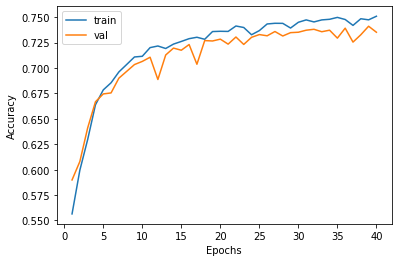

In [ ]:
# your code goes here
x = range(1,len(history4_1_untrainable.history["accuracy"])+1)
y4_1_ut_1 = history4_1_untrainable.history["accuracy"]
y4_1_ut_2 = history4_1_untrainable.history["val_accuracy"]

plt.plot(x,y4_1_ut_1, label="train")
plt.plot(x,y4_1_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

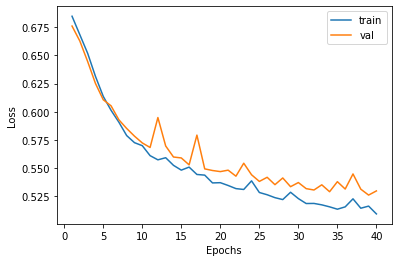

In [ ]:
# your code goes here
x = range(1,len(history4_1_untrainable.history["loss"])+1)
y4_1_ut_1 = history4_1_untrainable.history["loss"]
y4_1_ut_2 = history4_1_untrainable.history["val_loss"]

plt.plot(x,y4_1_ut_1, label="train")
plt.plot(x,y4_1_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Adding two extra dense layers

In [ ]:
def create_model4_2(isTrainable):

  return Sequential([
     Input((256,)),
     createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=isTrainable),
     GlobalAveragePooling1DMasked(),
     Dense(300, activation="relu"),
     Dense(300, activation="relu"),
     Dense(100, activation="relu"),
     Dense(16, activation="relu"),
     Dense(1, activation="sigmoid")
  ])

model4_2_trainable = tpu_model(lambda : create_model4_2(isTrainable=True))

model4_2_trainable.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 300)               90300     
                                                                 
 dense_7 (Dense)             (None, 300)               90300     
                                                                 
 dense_8 (Dense)             (None, 100)               30100     
                                                      

In [ ]:
model4_2_trainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history4_2_trainable = model4_2_trainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4_2_trainable = model4_2_trainable.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 23s 357ms/step - loss: 0.6688 - accuracy: 0.5911 - val_loss: 0.6959 - val_accuracy: 0.5574
Epoch 2/40
30/30 [==============================] - 4s 132ms/step - loss: 0.5720 - accuracy: 0.7122 - val_loss: 0.5422 - val_accuracy: 0.7332
Epoch 3/40
30/30 [==============================] - 4s 138ms/step - loss: 0.4023 - accuracy: 0.8255 - val_loss: 0.3867 - val_accuracy: 0.8321
Epoch 4/40
30/30 [==============================] - 4s 132ms/step - loss: 0.2982 - accuracy: 0.8780 - val_loss: 0.3262 - val_accuracy: 0.8687
Epoch 5/40
30/30 [==============================] - 4s 132ms/step - loss: 0.2302 - accuracy: 0.9095 - val_loss: 0.5396 - val_accuracy: 0.7962
Epoch 6/40
30/30 [==============================] - 4s 133ms/step - loss: 0.2294 - accuracy: 0.9080 - val_loss: 0.3244 - val_accuracy: 0.8717
Epoch 7/40
30/30 [==============================] - 4s 134ms/step - loss: 0.1523 - accuracy: 0.9445 - val_loss: 0.3251 - val_accuracy: 0.8774
Epoch

In [ ]:
results4_2_trainable = model4_2_trainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 20s 25ms/step - loss: 1.7369 - accuracy: 0.8431


In [ ]:
print(results4_2_trainable)

[1.736938714981079, 0.8431199789047241]


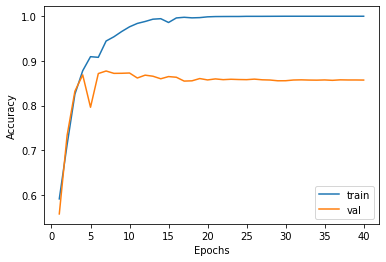

In [ ]:
# your code goes here
x = range(1,len(history4_2_trainable.history["accuracy"])+1)
y4_2_t_1 = history4_2_trainable.history["accuracy"]
y4_2_t_2 = history4_2_trainable.history["val_accuracy"]

plt.plot(x,y4_2_t_1, label="train")
plt.plot(x,y4_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

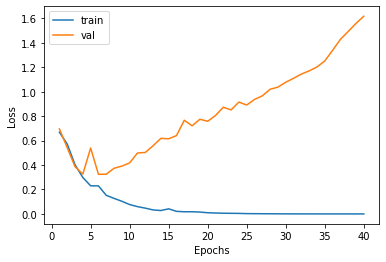

In [ ]:
# your code goes here
x = range(1,len(history4_2_trainable.history["loss"])+1)
y4_2_t_1 = history4_2_trainable.history["loss"]
y4_2_t_2 = history4_2_trainable.history["val_loss"]

plt.plot(x,y4_2_t_1, label="train")
plt.plot(x,y4_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:


model4_2_untrainable = tpu_model(lambda : create_model4_2(isTrainable=False))

model4_2_untrainable.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_3 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_11 (Dense)            (None, 300)               90300     
                                                                 
 dense_12 (Dense)            (None, 300)               90300     
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                      

In [ ]:
model4_2_untrainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history4_2_untrainable = model4_2_untrainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results4_2_untrainable = model4_2_untrainable.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 2s 78ms/step - loss: 0.6417 - accuracy: 0.6388 - val_loss: 0.6153 - val_accuracy: 0.6673
Epoch 2/40
30/30 [==============================] - 2s 78ms/step - loss: 0.5995 - accuracy: 0.6837 - val_loss: 0.5960 - val_accuracy: 0.6867
Epoch 3/40
30/30 [==============================] - 2s 66ms/step - loss: 0.5798 - accuracy: 0.7015 - val_loss: 0.5731 - val_accuracy: 0.7056
Epoch 4/40
30/30 [==============================] - 2s 67ms/step - loss: 0.5734 - accuracy: 0.7071 - val_loss: 0.5737 - val_accuracy: 0.7049
Epoch 5/40
30/30 [==============================] - 2s 67ms/step - loss: 0.5620 - accuracy: 0.7159 - val_loss: 0.5627 - val_accuracy: 0.7127
Epoch 6/40
30/30 [==============================] - 2s 67ms/step - loss: 0.5661 - accuracy: 0.7101 - val_loss: 0.5918 - val_accuracy: 0.6923
Epoch 7/40
30/30 [==============================] - 2s 66ms/step - loss: 0.5557 - accuracy: 0.7199 - val_loss: 0.5539 - val_accuracy: 0.7212
Epoch 8/40
30

In [ ]:
results4_2_untrainable = model4_2_untrainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 20s 25ms/step - loss: 0.5394 - accuracy: 0.7349


In [ ]:
print(results4_2_untrainable)

[0.5394036173820496, 0.7349200248718262]


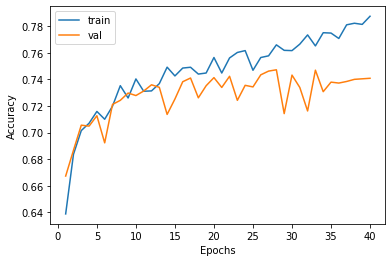

In [ ]:
# your code goes here
x = range(1,len(history4_2_untrainable.history["accuracy"])+1)
y4_2_ut_1 = history4_2_untrainable.history["accuracy"]
y4_2_ut_2 = history4_2_untrainable.history["val_accuracy"]

plt.plot(x,y4_2_ut_1, label="train")
plt.plot(x,y4_2_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

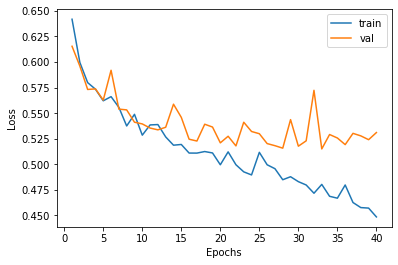

In [ ]:
# your code goes here
x = range(1,len(history4_2_untrainable.history["loss"])+1)
y4_2_ut_1 = history4_2_untrainable.history["loss"]
y4_2_ut_2 = history4_2_untrainable.history["val_loss"]

plt.plot(x,y4_2_ut_1, label="train")
plt.plot(x,y4_2_ut_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

##  Model 5-1: Basic CNN model for Text Classification 

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use pre-trained embeddings or scratch train them from scratch.

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [ ]:
def create_model5_1(isTrainable):
  return Sequential([
    Input((256,)),
    createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=isTrainable),
    Conv1D(100, 6, strides=1),
    GlobalMaxPooling1D(),
    Dense(1, activation="sigmoid")
  ])

model5_1_trainable = tpu_model(lambda : create_model5_1(isTrainable=True))

model5_1_trainable.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 251, 100)          180100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 120,180,501
Trainable params: 120,180,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model5_1_trainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history5_1_trainable = model5_1_trainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results5_1_trainable = model5_1_trainable.evaluate(X_test_enc, y_test)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 21s 437ms/step - loss: 0.8077 - accuracy: 0.5359 - val_loss: 0.6410 - val_accuracy: 0.6189
Epoch 2/40
30/30 [==============================] - 4s 134ms/step - loss: 0.5322 - accuracy: 0.7675 - val_loss: 0.5389 - val_accuracy: 0.7473
Epoch 3/40
30/30 [==============================] - 4s 126ms/step - loss: 0.4264 - accuracy: 0.8653 - val_loss: 0.4874 - val_accuracy: 0.7791
Epoch 4/40
30/30 [==============================] - 4s 128ms/step - loss: 0.3525 - accuracy: 0.9063 - val_loss: 0.4528 - val_accuracy: 0.7965
Epoch 5/40
30/30 [==============================] - 4s 128ms/step - loss: 0.2930 - accuracy: 0.9311 - val_loss: 0.4248 - val_accuracy: 0.8068
Epoch 6/40
30/30 [==============================] - 4s 135ms/step - loss: 0.2408 - accuracy: 0.9531 - val_loss: 0.3988 - val_accuracy: 0.8203
Epoch 7/40
30/30 [==============================] - 4s 127ms/step - loss: 0.1976 - accuracy: 0.9705 - val_loss: 0.3818 - val_accuracy: 0.8300
Epoch 8/40
30/30

In [ ]:
results5_1_trainable = model5_1_trainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 18s 22ms/step - loss: 0.3548 - accuracy: 0.8638


In [ ]:
print(results5_1_trainable)

[0.3548033535480499, 0.8637599945068359]


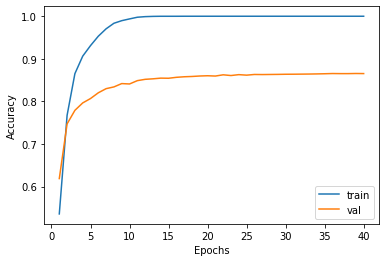

In [ ]:
# your code goes here
x = range(1,len(history5_1_trainable.history["accuracy"])+1)
y5_1_t_1 = history5_1_trainable.history["accuracy"]
y5_1_t_2 = history5_1_trainable.history["val_accuracy"]

plt.plot(x,y5_1_t_1, label="train")
plt.plot(x,y5_1_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Train and test the model, also plot train and validation accuracy and loss over epochs.

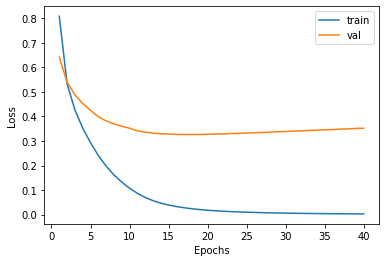

In [ ]:
# your code goes here
x = range(1,len(history5_1_trainable.history["loss"])+1)
y5_1_t_1 = history5_1_trainable.history["loss"]
y5_1_t_2 = history5_1_trainable.history["val_loss"]

plt.plot(x,y5_1_t_1, label="train")
plt.plot(x,y5_1_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Model 5-2: Adding extra convolutional layer

In [ ]:
def create_model5_2(isTrainable):
  return Sequential([
    Input((256,)),
    createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=isTrainable),
    Conv1D(100, 6, strides=1),
    Conv1D(100, 6, strides=1),
    GlobalMaxPooling1D(),
    Dense(1, activation="sigmoid")
  ])

model5_2_trainable = tpu_model(lambda : create_model5_2(isTrainable=True))

model5_2_trainable.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 100)          60100     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,240,601
Trainable params: 120,240,60

In [ ]:
model5_2_trainable.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train and test the model

history5_2_trainable = model5_2_trainable.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results5_2_trainable = model5_2_trainable.evaluate(X_test_enc, y_test)

Epoch 1/40
30/30 [==============================] - 23s 486ms/step - loss: 0.6977 - accuracy: 0.5783 - val_loss: 0.6216 - val_accuracy: 0.6511
Epoch 2/40
30/30 [==============================] - 4s 125ms/step - loss: 0.5007 - accuracy: 0.7894 - val_loss: 0.5189 - val_accuracy: 0.7472
Epoch 3/40
30/30 [==============================] - 4s 146ms/step - loss: 0.3855 - accuracy: 0.8613 - val_loss: 0.4843 - val_accuracy: 0.7692
Epoch 4/40
30/30 [==============================] - 4s 134ms/step - loss: 0.2964 - accuracy: 0.9143 - val_loss: 0.4545 - val_accuracy: 0.7821
Epoch 5/40
30/30 [==============================] - 4s 128ms/step - loss: 0.2252 - accuracy: 0.9487 - val_loss: 0.4225 - val_accuracy: 0.8026
Epoch 6/40
30/30 [==============================] - 4s 127ms/step - loss: 0.1631 - accuracy: 0.9756 - val_loss: 0.4060 - val_accuracy: 0.8128
Epoch 7/40
30/30 [==============================] - 4s 135ms/step - loss: 0.1149 - accuracy: 0.9914 - val_loss: 0.3983 - val_accuracy: 0.8181
Epoch

In [ ]:
results5_2_trainable = model5_2_trainable.evaluate(X_test_enc, y_test)

782/782 [==============================] - 18s 22ms/step - loss: 0.4557 - accuracy: 0.8504


In [ ]:
print(results5_2_trainable)

[0.4556541442871094, 0.8503599762916565]


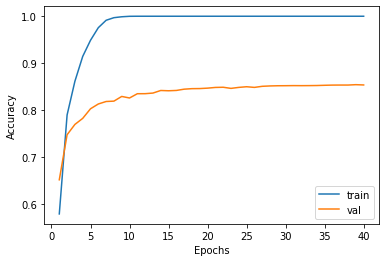

In [ ]:
# your code goes here
x = range(1,len(history5_2_trainable.history["accuracy"])+1)
y5_2_t_1 = history5_2_trainable.history["accuracy"]
y5_2_t_2 = history5_2_trainable.history["val_accuracy"]

plt.plot(x,y5_2_t_1, label="train")
plt.plot(x,y5_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

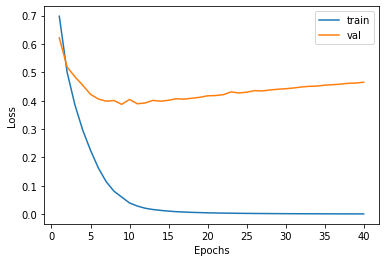

In [ ]:
# your code goes here
x = range(1,len(history5_2_trainable.history["loss"])+1)
y5_2_t_1 = history5_2_trainable.history["loss"]
y5_2_t_2 = history5_2_trainable.history["val_loss"]

plt.plot(x,y5_2_t_1, label="train")
plt.plot(x,y5_2_t_2, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Train and test the model, also plot train and validation accuracy and loss over epochs.

Although adding a layer here reduces the training loss, the evaluation accuracy is worse than for the model without the extra convolutional layer.

 Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit. Overfitting can lead to errors, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in this hidden layer is between the number of network input dimensions and the number of output dimensions.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor their performance.







---

